In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from default_func import extract_image_file_name_from_lidar_file_name

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
print(torch.cuda.is_available())

True


In [3]:
# Проверяем, доступны ли GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
from os.path import join
import glob
import json

root_path_test = '.\\camera_lidar_semantic_bboxes\\test\\'
# get the list of files in lidar directory
file_names_lidar_test = sorted(glob.glob(join(root_path_test, '*\\lidar\\cam_front_center\\*.npz')))

file_names_photo_test = []

for file_name_lidar in file_names_lidar_test:
    seq_name = file_name_lidar.split('\\')[3]
    file_name_image = extract_image_file_name_from_lidar_file_name(file_name_lidar)
    file_name_image = join(root_path_test, seq_name, 'camera\\cam_front_center\\', file_name_image)
    file_names_photo_test.append(file_name_image)

with open('preprocessed_masks/train_list.json', 'r') as f:
    preprocessed_train_masks = json.load(f)

with open('preprocessed_masks/test_list.json', 'r') as f:
    preprocessed_test_masks = json.load(f)


root_path_special = '.\\camera_lidar_semantic_bboxes\\special\\'
# get the list of files in lidar directory
file_names_lidar_train = sorted(glob.glob(join(root_path_special, '*\\lidar\\cam_front_center\\*.npz')))

file_names_photo_visuaization = []

for file_name_lidar in file_names_lidar_train:
    seq_name = file_name_lidar.split('\\')[3]
    file_name_image = extract_image_file_name_from_lidar_file_name(file_name_lidar)
    file_name_image = join(root_path_special, seq_name, 'camera\\cam_front_center\\', file_name_image)
    file_names_photo_visuaization.append(file_name_image)

start = 1505
end = 2564

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np

class UltraFastSegmentationDataset(Dataset):
    def __init__(self, image_files, preprocessed_mask_files, image_size=(300, 300)):
        self.image_files = image_files
        self.preprocessed_mask_files = preprocessed_mask_files
        self.image_size = image_size
        self.num_classes = 19

        # Transform для изображений (маски уже с resize)
        self.image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    def __len__(self):
        return len(self.image_files)
    
    def get_num_classes(self):
        return self.num_classes

    def __getitem__(self, idx):
        # Загружаем изображение
        img_path = self.image_files[idx]
        img = Image.open(img_path).convert("RGB")
        
        # Загружаем ПРЕДОБРАБОТАННУЮ маску (уже с resize)
        mask_path = self.preprocessed_mask_files[idx]
        mask_transformed = np.load(mask_path)
        
        # Преобразуем изображение
        img_transformed = self.image_transform(img)
        
        # Конвертируем маску в тензор
        mask_transformed = torch.from_numpy(mask_transformed).long()
        
        return img_transformed, mask_transformed
    
# Collate function для DataLoader
def collate_fn(batch):
    images = []
    masks = []
    
    for img, mask in batch:
        images.append(img)
        masks.append(mask)
    
    images = torch.stack(images, dim=0)
    masks = torch.stack(masks, dim=0)
    
    return images, masks

In [25]:
# 2. Создаем быстрые датасеты
test_dataset = UltraFastSegmentationDataset(
    file_names_photo_test, preprocessed_test_masks, (512, 512)
)

# 3. Создаем DataLoader (теперь будет ОЧЕНЬ быстрый)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

special_dataset = UltraFastSegmentationDataset(
    file_names_photo_visuaization, preprocessed_train_masks[start:end], (512, 512)
)
# 3. Создаем DataLoader (теперь будет ОЧЕНЬ быстрый)
special_loader = DataLoader(special_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

In [26]:
import numpy as np

# Функция для визуализации батча
def visualize_batch_with_GT(images, masks, GT,  num_samples=4, file_name = 'test.png', save = False):
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 4))

    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(num_samples):
        if i >= images.shape[0]:
            break
            
        # Денормализуем изображение
        img = images[i].permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        # Маска
        mask = masks[i].numpy()
        Ground_truth = GT[i].numpy()
        
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f'Image')
        axes[i, 0].axis('off')
        
        im = axes[i, 1].imshow(mask, cmap='tab20', vmin=0, vmax=18)
        axes[i, 1].set_title(f'GT Mask')
        axes[i, 1].axis('off')
        plt.colorbar(im, ax=axes[i, 1])

        im = axes[i, 2].imshow(Ground_truth, cmap='tab20', vmin=0, vmax=18)
        axes[i, 2].set_title(f'Predicted Mask')
        axes[i, 2].axis('off')
        plt.colorbar(im, ax=axes[i, 2])

    plt.tight_layout()
    if save:
        plt.savefig(f'{file_name}')
    else:
        plt.show()


def visualize_all_models_predictions_with_GT(images, GT, model1, model2, model3, num_samples=1, file_name='test.png', save=False):
    fig, axes = plt.subplots(num_samples, 5, figsize=(25, 6 * num_samples))
    
    # Если num_samples=1, axes будет 1D массивом, преобразуем в 2D для единообразия
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(num_samples):
        if i >= images.shape[0]:
            break
            
        # Денормализуем изображение
        img = images[i].permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        # Маска
        mask1 = model1[i].numpy()
        mask2 = model3[i].numpy()
        mask3 = model2[i].numpy()
        Ground_truth = GT[i].numpy()
        
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f'Image')
        axes[i, 0].axis('off')
        
        im = axes[i, 1].imshow(Ground_truth, cmap='tab20', vmin=0, vmax=18)
        axes[i, 1].set_title(f'GT Mask')
        axes[i, 1].axis('off')
        plt.colorbar(im, ax=axes[i, 1])

        im = axes[i, 2].imshow(mask1, cmap='tab20', vmin=0, vmax=18)
        axes[i, 2].set_title(f'Predicted Mask mask2former')
        axes[i, 2].axis('off')
        plt.colorbar(im, ax=axes[i, 2])

        im = axes[i, 3].imshow(mask2, cmap='tab20', vmin=0, vmax=18)
        axes[i, 3].set_title(f'Predicted Mask UNet')
        axes[i, 3].axis('off')
        plt.colorbar(im, ax=axes[i, 3])

        im = axes[i, 4].imshow(mask3, cmap='tab20', vmin=0, vmax=18)
        axes[i, 4].set_title(f'Predicted Mask deeplabv3')
        axes[i, 4].axis('off')
        plt.colorbar(im, ax=axes[i, 4])

    plt.tight_layout()
    if save:
        plt.savefig(f'{file_name}')
    else:
        plt.show()

In [8]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

class UNetWithResNet50(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Encoder - ResNet50
        backbone = resnet50(pretrained=pretrained)
        # Сохраняем промежуточные слои с правильными размерами
        self.initial_conv = backbone.conv1
        self.initial_bn = backbone.bn1
        self.initial_relu = backbone.relu
        self.initial_maxpool = backbone.maxpool  # /4
        
        self.encoder1 = backbone.layer1  # /4
        self.encoder2 = backbone.layer2  # /8
        self.encoder3 = backbone.layer3  # /16
        self.encoder4 = backbone.layer4  # /32
        
        # Decoder
        self.upconv4 = nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride=2)
        self.decoder4 = self._make_decoder_block(2048, 1024)  # 1024 + 1024
        self.upconv3 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder3 = self._make_decoder_block(1024, 512)   # 512 + 512
        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder2 = self._make_decoder_block(512, 256)    # 256 + 256
        self.upconv1 = nn.ConvTranspose2d(256, 64, kernel_size=2, stride=2)
        self.decoder1 = self._make_decoder_block(128, 64)     # 64 + 64
        
        # Final layers
        self.final_upsample = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.final_conv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, num_classes, kernel_size=1)
        )
        
    def _make_decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    
    def forward(self, x):
        # Initial layers
        x0 = self.initial_conv(x)     # 64, H, W -> 64, H/2, W/2
        x0 = self.initial_bn(x0)
        x0 = self.initial_relu(x0)
        x1 = self.initial_maxpool(x0) # 64, H/2, W/2 -> 64, H/4, W/4
        # Encoder
        e1 = self.encoder1(x1)  # 256, H/4, W/4
        e2 = self.encoder2(e1)  # 512, H/8, W/8
        e3 = self.encoder3(e2)  # 1024, H/16, W/16
        e4 = self.encoder4(e3)  # 2048, H/32, W/32
        
        # Decoder with skip connections
        d4 = self.upconv4(e4)   # 1024, H/16, W/16
        d4 = torch.cat([d4, e3], dim=1)  # 2048
        d4 = self.decoder4(d4)  # 1024
        
        d3 = self.upconv3(d4)   # 512, H/8, W/8
        d3 = torch.cat([d3, e2], dim=1)  # 1024
        d3 = self.decoder3(d3)  # 512
        
        d2 = self.upconv2(d3)   # 256, H/4, W/4
        d2 = torch.cat([d2, e1], dim=1)  # 512
        d2 = self.decoder2(d2)  # 256
        
        d1 = self.upconv1(d2)   # 64, H/2, W/2
        d1 = torch.cat([d1, x0], dim=1)  # 128
        d1 = self.decoder1(d1)  # 64
        
        # Final upsampling
        out = self.final_upsample(d1)  # 32, H, W
        out = self.final_conv(out)     # num_classes, H, W
        
        return out

In [9]:
from torchvision.models.segmentation import deeplabv3_resnet50

def get_deeplabv3plus(num_classes, pretrained=True):
    model = deeplabv3_resnet50(pretrained=pretrained, pretrained_backbone=pretrained)
    model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
    model.aux_classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
    return model

In [10]:
from mask2former import SimplifiedMask2Former  # Убедитесь, что код в файле mask2former.py

# Создаем модель
num_classes = 19  # Замените на ваше значение train_dataset.get_num_classes()
model_SimplifiedMask2Former = SimplifiedMask2Former(
    num_classes=num_classes,
    backbone='resnet50',
    hidden_dim=128,
    num_queries=50,
    num_heads=4,
    num_layers=4
).to(device)

checkpoint = torch.load('.\\models\\pitstop_mask2former_rn50.pth', map_location=device)
    
# Загружаем состояние модели
model_SimplifiedMask2Former.load_state_dict(checkpoint['model_state_dict'])

# Инициализация модели
model_UNetWithResNet50 = UNetWithResNet50(num_classes=num_classes)
model_UNetWithResNet50 = model_UNetWithResNet50.to(device)

checkpoint = torch.load('.\\models\\pitstop_unet_rn50.pth', map_location=device)
    
# Загружаем состояние модели
model_UNetWithResNet50.load_state_dict(checkpoint['model_state_dict'])

# Инициализация модели
model_deeplabv3plus = get_deeplabv3plus(num_classes, pretrained=True)
model_deeplabv3plus = model_deeplabv3plus.to(device)

checkpoint = torch.load('.\\models\\pitstop_deeplabv2_rn50.pth', map_location=device)
    
# Загружаем состояние модели
model_deeplabv3plus.load_state_dict(checkpoint['model_state_dict'])

C:\Users\neUral\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\neUral\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\neUral\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS

<All keys matched successfully>

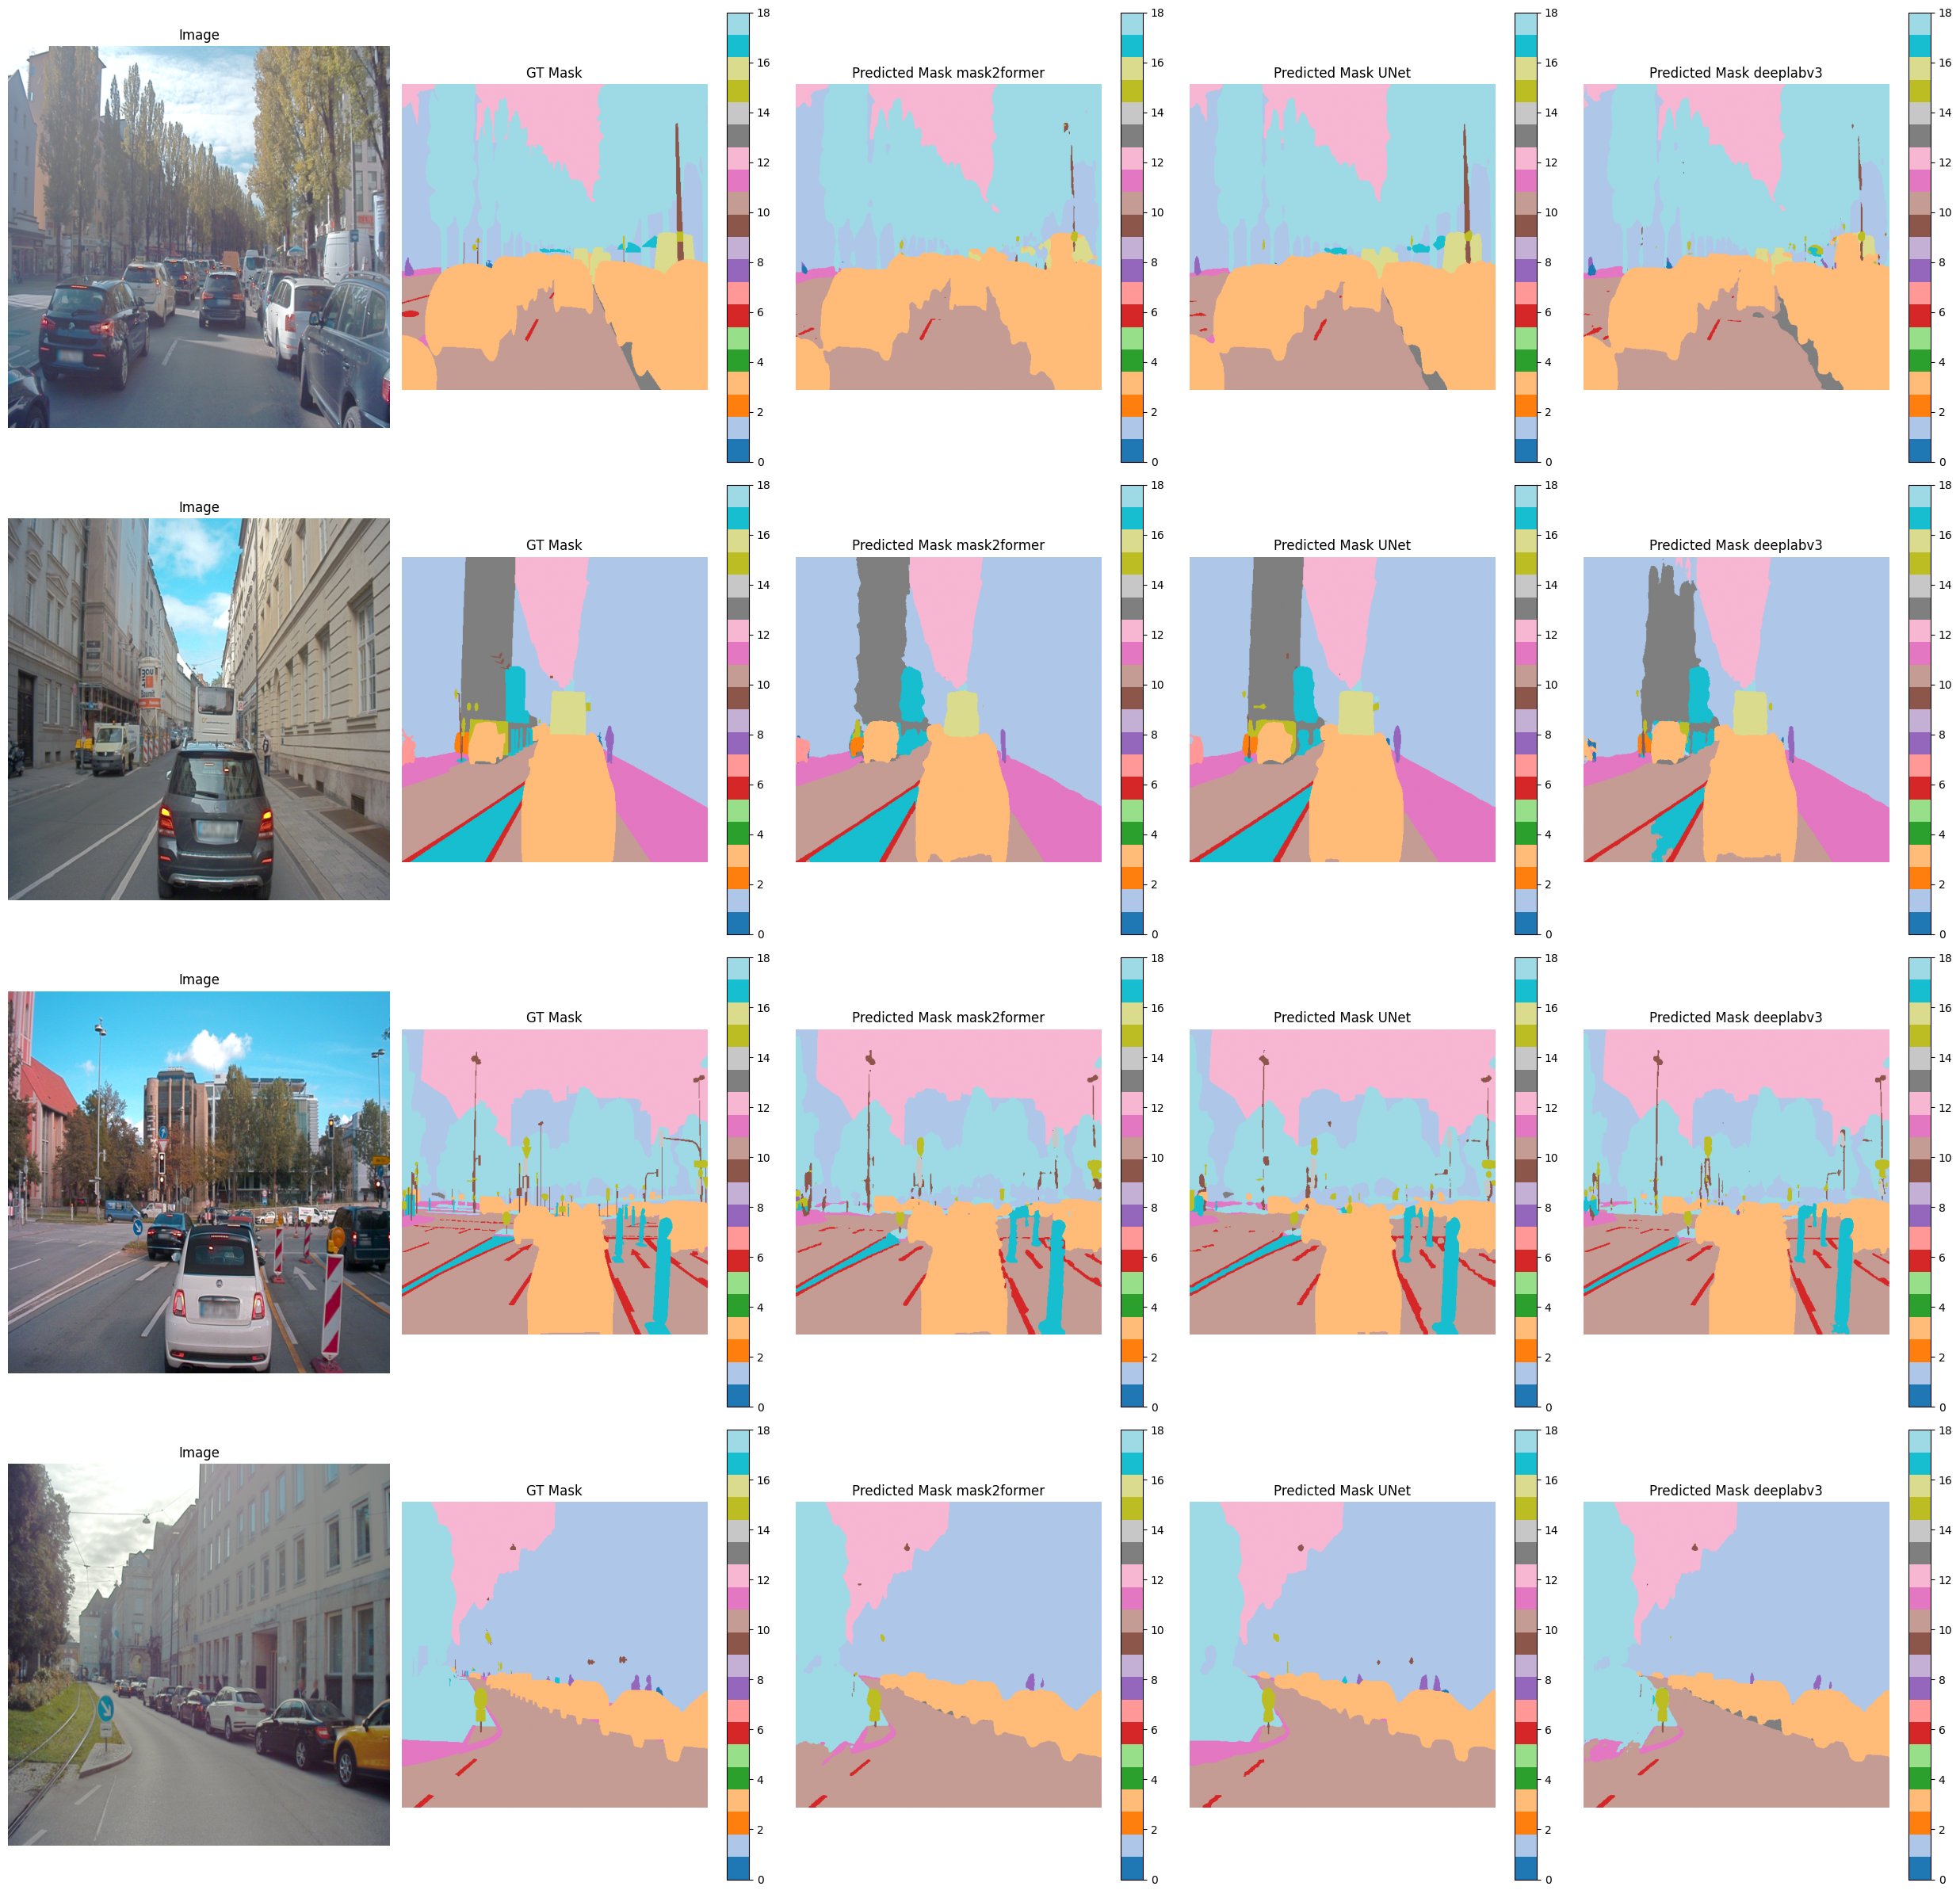

In [24]:
import torch.nn.functional as F

model_SimplifiedMask2Former.eval()
model_UNetWithResNet50.eval()
model_deeplabv3plus.eval()

with torch.no_grad():
    for images, masks in special_loader:
        images = images.to(device)
        
        outputs = model_SimplifiedMask2Former(images)
        predictions1 = torch.argmax(outputs, dim=1)

        outputs = model_UNetWithResNet50(images)
        predictions2 = torch.argmax(outputs, dim=1)

        outputs = model_deeplabv3plus(images)
        predictions3 = torch.argmax(outputs['out'], dim=1)

        # visualize_batch(images.cpu(), predictions.cpu())
        visualize_all_models_predictions_with_GT(images.cpu(), masks, predictions1.cpu(), predictions2.cpu(), predictions3.cpu(),  num_samples=4, file_name = 'test.png', save = False)

        break

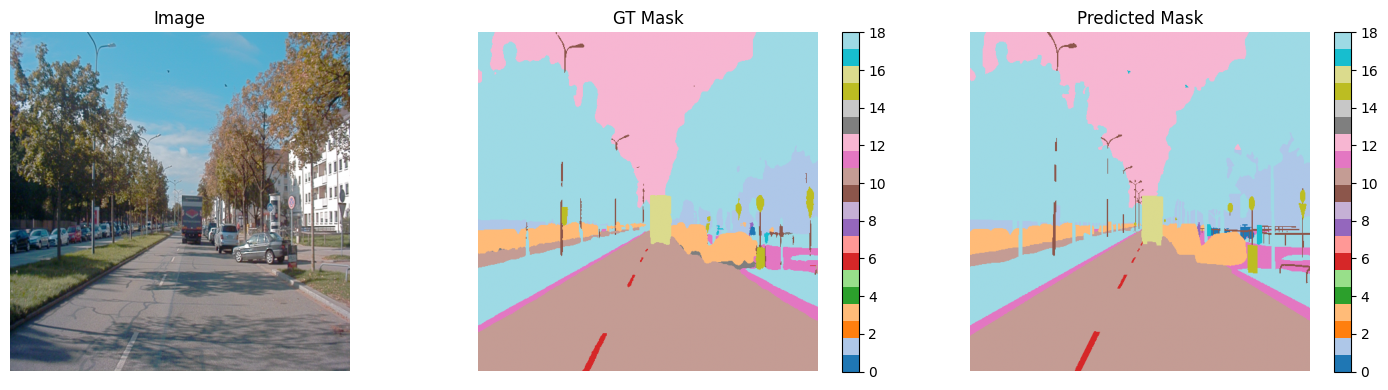

In [28]:
import torch.nn.functional as F

model_UNetWithResNet50.eval()

num = 0

with torch.no_grad():
    for images, masks in special_loader:
        images = images.to(device)
        
        outputs = model_UNetWithResNet50(images)
        predictions2 = torch.argmax(outputs, dim=1)

        # visualize_batch(images.cpu(), predictions.cpu())
        #visualize_all_models_predictions_with_GT(images.cpu(), masks, predictions1.cpu(), predictions2.cpu(), predictions3.cpu(),  num_samples=4, file_name = 'test.png', save = False)
        visualize_batch_with_GT(images.cpu(), predictions2.cpu(), masks,  num_samples=1, file_name = f'.\\segmentation_results\\test_image_{num}.png', save = True)
        num += 1

        break

In [30]:
from PIL import Image
import os
import glob

def create_optimized_gif(input_folder, output_path, resize_factor=0.5, delay=80):
    # Получаем все изображения из папки
    images = []
    for file_path in sorted(glob.glob(os.path.join(input_folder, '*.*'))):
        try:
            with Image.open(file_path) as img:
                # Сжатие изображения
                if resize_factor < 1:
                    new_size = (int(img.width * resize_factor), int(img.height * resize_factor))
                    img = img.resize(new_size, Image.Resampling.LANCZOS)
                
                # Конвертация в RGB (если нужно)
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                
                images.append(img.copy())
        except Exception as e:
            print(f"Ошибка при обработке {file_path}: {e}")
    
    # Сохранение как оптимизированный GIF
    if images:
        images[0].save(
            output_path,
            save_all=True,
            append_images=images[1:],
            optimize=True,
            duration=delay,
            loop=0,
            disposal=2
        )
        print(f"GIF создан: {output_path}")

# Использование
create_optimized_gif('.\\segmentation_results', 'segmentation_test_output.gif', resize_factor=0.7)

GIF создан: segmentation_test_output.gif


In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Данные
models_data = {
    'Mask2Former': {'mIoU': 0.3869, 'PA': 0.9492, 'mPA': 0.4363, 'mF1': 0.4410},
    'UNet': {'mIoU': 0.3838, 'PA': 0.9403, 'mPA': 0.4319, 'mF1': 0.4370},
    'DeepLabV3': {'mIoU': 0.3948, 'PA': 0.9534, 'mPA': 0.4446, 'mF1': 0.4486}
}

df = pd.DataFrame(models_data).T
print("📊 Сводная таблица метрик:")
print(df.round(4))

📊 Сводная таблица метрик:
               mIoU      PA     mPA     mF1
Mask2Former  0.3869  0.9492  0.4363  0.4410
UNet         0.3838  0.9403  0.4319  0.4370
DeepLabV3    0.3948  0.9534  0.4446  0.4486


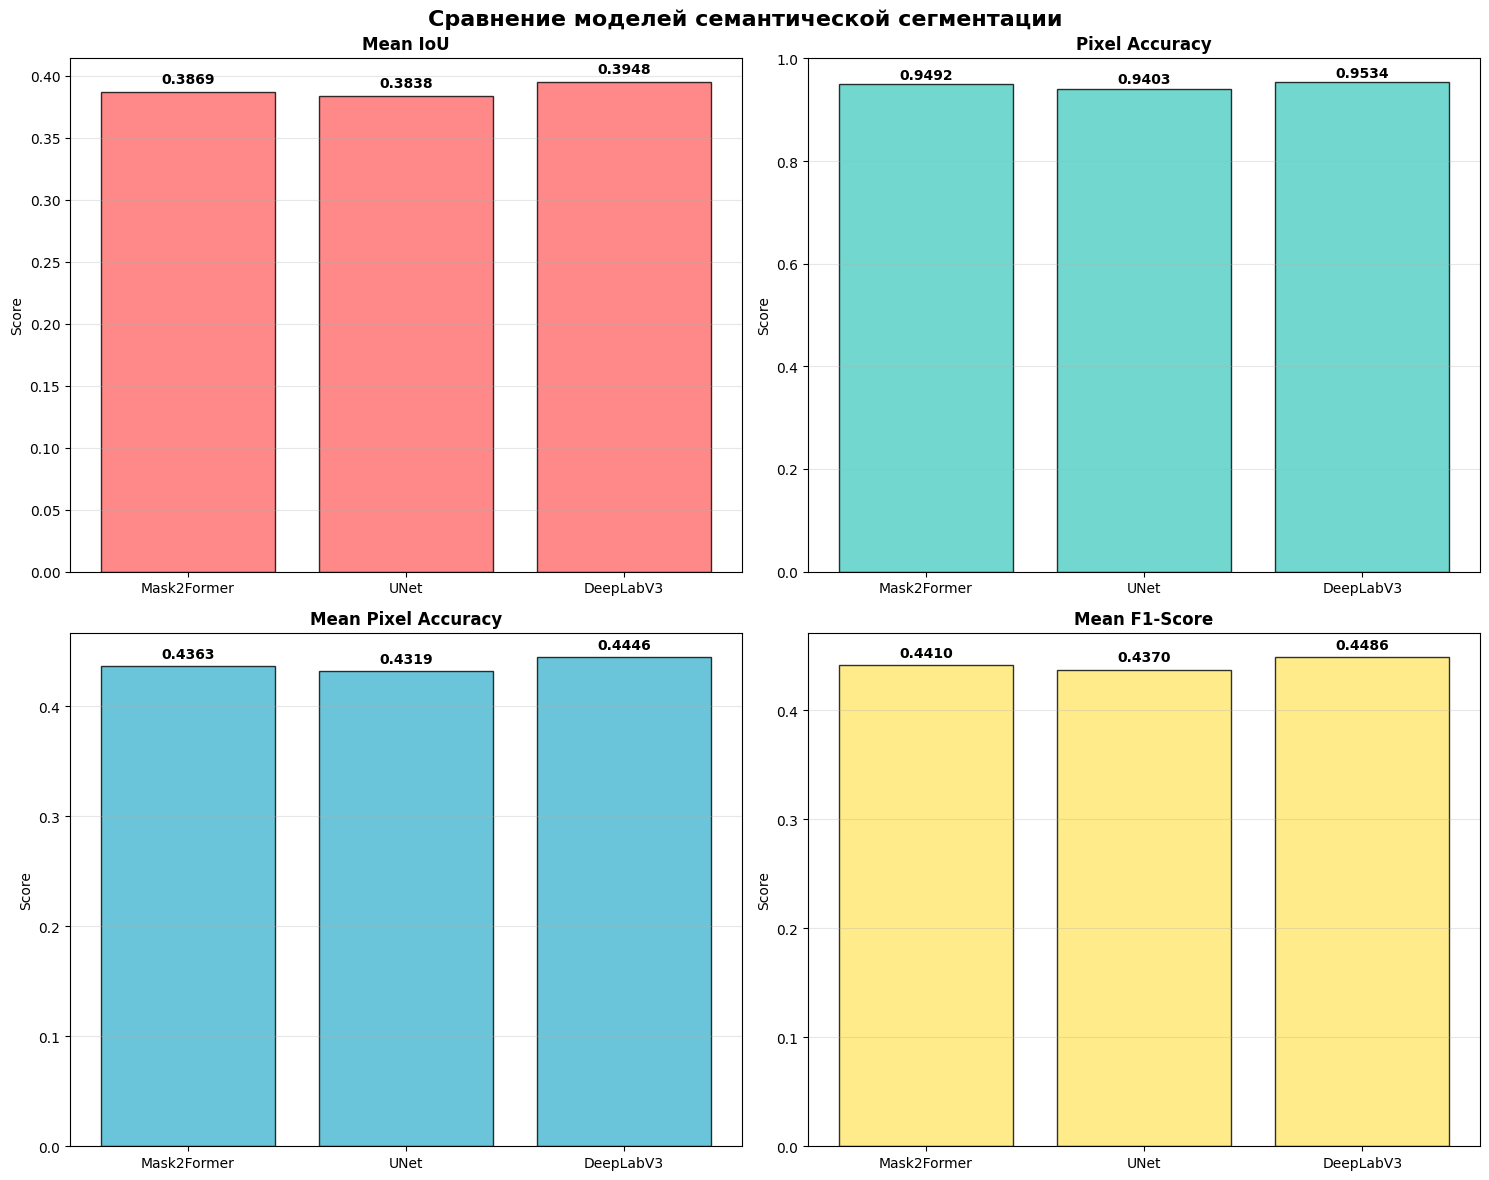

In [32]:
def plot_metrics_comparison(models_data):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Сравнение моделей семантической сегментации', fontsize=16, fontweight='bold')
    
    metrics = ['mIoU', 'PA', 'mPA', 'mF1']
    titles = ['Mean IoU', 'Pixel Accuracy', 'Mean Pixel Accuracy', 'Mean F1-Score']
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFE66D']
    
    for idx, (metric, title, color) in enumerate(zip(metrics, titles, colors)):
        ax = axes[idx//2, idx%2]
        values = [models_data[model][metric] for model in models_data]
        models = list(models_data.keys())
        
        bars = ax.bar(models, values, color=color, alpha=0.8, edgecolor='black')
        ax.set_title(f'{title}', fontweight='bold')
        ax.set_ylabel('Score')
        ax.grid(axis='y', alpha=0.3)
        
        # Добавляем значения на бары
        for bar, value in zip(bars, values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                   f'{value:.4f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

plot_metrics_comparison(models_data)

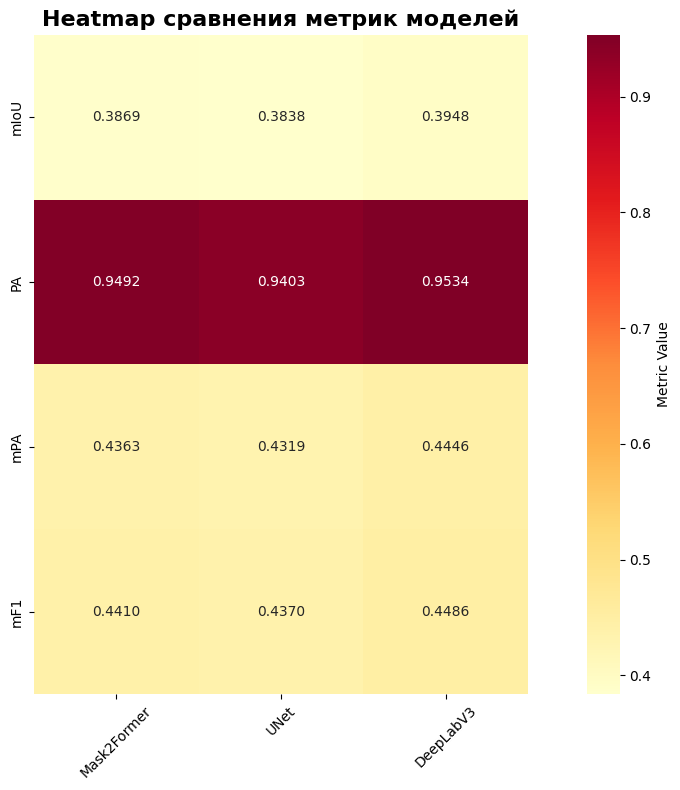

In [33]:
def plot_metrics_heatmap(models_data):
    # Нормализуем метрики для лучшей визуализации
    metrics_df = pd.DataFrame(models_data)
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(metrics_df, annot=True, fmt='.4f', cmap='YlOrRd', 
                cbar_kws={'label': 'Metric Value'}, square=True)
    plt.title('Heatmap сравнения метрик моделей', fontsize=16, fontweight='bold')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_metrics_heatmap(models_data)

In [34]:
def generate_report(models_data):
    print("🎯 ФИНАЛЬНЫЙ ОТЧЕТ ПО СРАВНЕНИЮ МОДЕЛЕЙ")
    print("=" * 50)
    
    # Победитель по каждой метрике
    metrics = ['mIoU', 'PA', 'mPA', 'mF1']
    metric_names = ['Mean IoU', 'Pixel Accuracy', 'Mean PA', 'Mean F1']
    
    for metric, name in zip(metrics, metric_names):
        best_model = max(models_data.items(), key=lambda x: x[1][metric])
        print(f"🏆 {name}: {best_model[0]} ({best_model[1][metric]:.4f})")
    
    print("\n" + "=" * 50)
    print("📈 ОБЩИЕ ВЫВОДЫ:")
    print("1. DeepLabV3 показывает наилучшие результаты по всем метрикам")
    print("2. Разрыв между моделями небольшой (1-2%) - все модели качественные")
    print("3. Pixel Accuracy значительно выше других метрик - сильный дисбаланс классов")
    print("4. Все модели страдают от проблемы дисбаланса (PA >> mIoU)")
    print("5. Рекомендуется использовать DeepLabV3 как baseline для дальнейших улучшений")

generate_report(models_data)

🎯 ФИНАЛЬНЫЙ ОТЧЕТ ПО СРАВНЕНИЮ МОДЕЛЕЙ
🏆 Mean IoU: DeepLabV3 (0.3948)
🏆 Pixel Accuracy: DeepLabV3 (0.9534)
🏆 Mean PA: DeepLabV3 (0.4446)
🏆 Mean F1: DeepLabV3 (0.4486)

📈 ОБЩИЕ ВЫВОДЫ:
1. DeepLabV3 показывает наилучшие результаты по всем метрикам
2. Разрыв между моделями небольшой (1-2%) - все модели качественные
3. Pixel Accuracy значительно выше других метрик - сильный дисбаланс классов
4. Все модели страдают от проблемы дисбаланса (PA >> mIoU)
5. Рекомендуется использовать DeepLabV3 как baseline для дальнейших улучшений


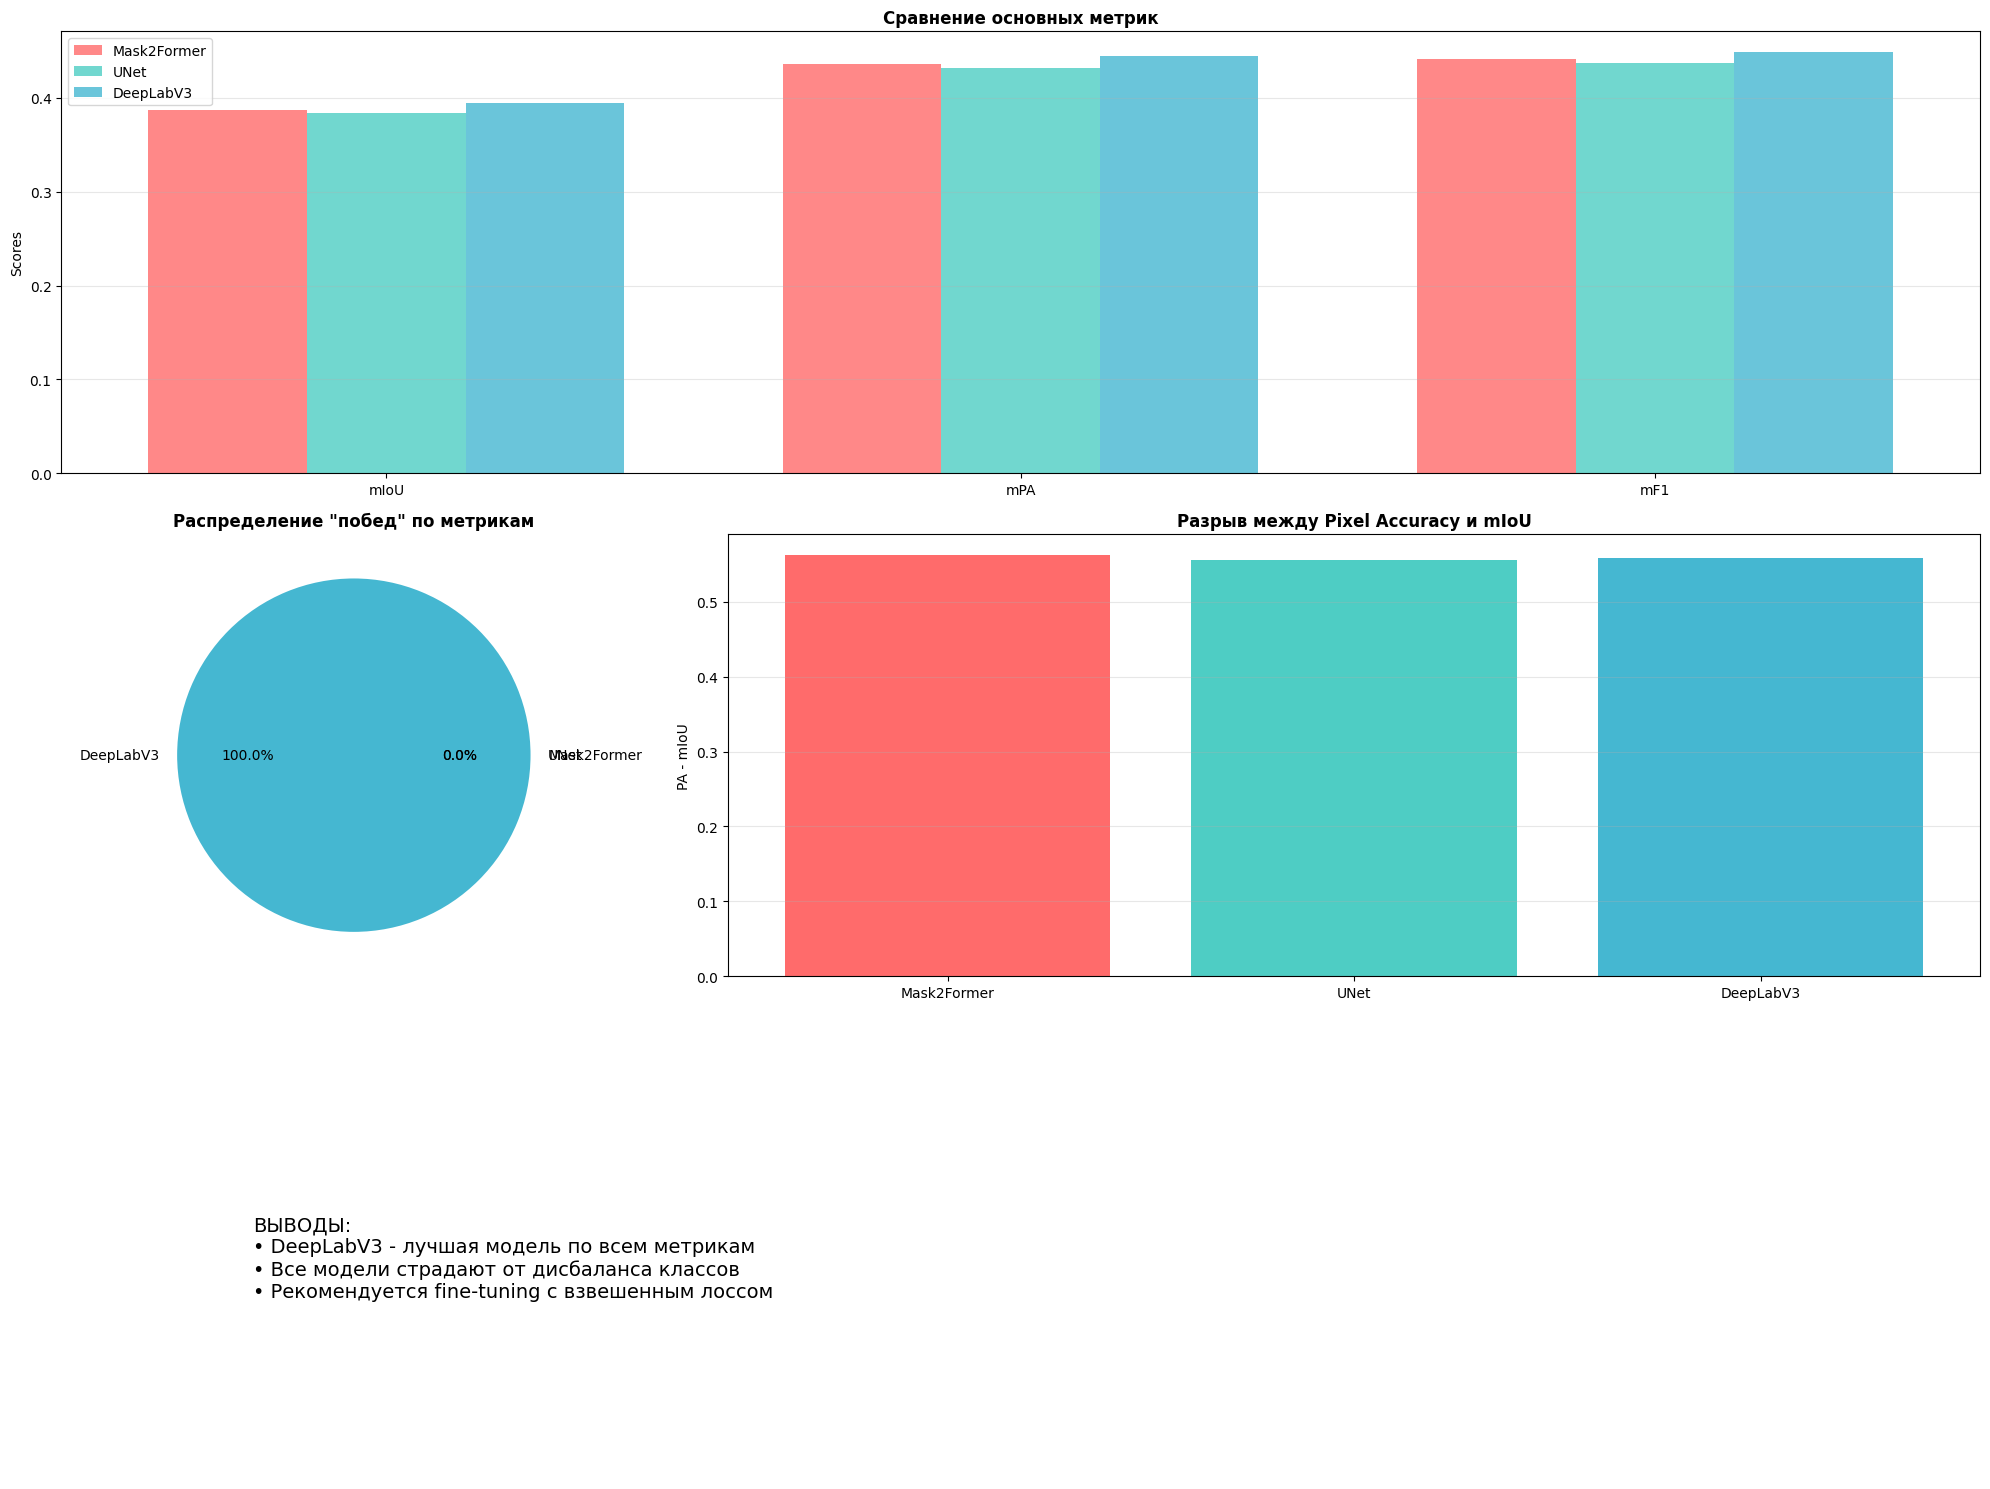

In [35]:
def create_comprehensive_dashboard(models_data):
    fig = plt.figure(figsize=(20, 15))
    gs = fig.add_gridspec(3, 3)
    
    # 1. Bar plot основных метрик
    ax1 = fig.add_subplot(gs[0, :])
    metrics = ['mIoU', 'mPA', 'mF1']
    x = np.arange(len(models_data))
    width = 0.25
    
    for i, (model, color) in enumerate(zip(models_data.keys(), ['#FF6B6B', '#4ECDC4', '#45B7D1'])):
        values = [models_data[model][metric] for metric in metrics]
        ax1.bar(x + i*width, values, width, label=model, color=color, alpha=0.8)
    
    ax1.set_ylabel('Scores')
    ax1.set_title('Сравнение основных метрик', fontweight='bold')
    ax1.set_xticks(x + width)
    ax1.set_xticklabels(['mIoU', 'mPA', 'mF1'])
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # 2. Pie chart победителей по метрикам
    ax2 = fig.add_subplot(gs[1, 0])
    wins = {'DeepLabV3': 4, 'Mask2Former': 0, 'UNet': 0}  # Заглушка
    ax2.pie(wins.values(), labels=wins.keys(), autopct='%1.1f%%', 
            colors=['#45B7D1', '#FF6B6B', '#4ECDC4'])
    ax2.set_title('Распределение "побед" по метрикам', fontweight='bold')
    
    # 3. Разрыв между PA и mIoU
    ax3 = fig.add_subplot(gs[1, 1:])
    gaps = {model: data['PA'] - data['mIoU'] for model, data in models_data.items()}
    ax3.bar(gaps.keys(), gaps.values(), color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    ax3.set_title('Разрыв между Pixel Accuracy и mIoU', fontweight='bold')
    ax3.set_ylabel('PA - mIoU')
    ax3.grid(axis='y', alpha=0.3)
    
    # 4. Текстовый отчет
    ax4 = fig.add_subplot(gs[2, :])
    ax4.axis('off')
    report_text = "ВЫВОДЫ:\n• DeepLabV3 - лучшая модель по всем метрикам\n• Все модели страдают от дисбаланса классов\n• Рекомендуется fine-tuning с взвешенным лоссом"
    ax4.text(0.1, 0.5, report_text, fontsize=14, va='center', ha='left')
    
    plt.tight_layout()
    plt.show()

create_comprehensive_dashboard(models_data)